# Impact of MP Votes In Parliament
Kyle Martens
December 19th, 2020

### Environment used

The environment was built with the following code:

`conda create -n PoliticalBill python numpy pandas
activate PoliticalBill
conda install matplotlib seaborn statsmodels scikit-learn plotly jupyter
conda install psycopg2
conda install wordcloud`

## Data Extraction

In this notebook, I will load the data from a Postgres SQL database and join it together.

### Table of Content
[Extracting the data](#extract)

[Making the a dataframe of an unvectorized description](#unvect)

[Wordcloud](#wordcloud)

#### Importing of libraries.

In [1]:
import psycopg2
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

### Extracting the data <a class="anchor" id="extract"></a>

In [2]:
#Establishing a connection to the database
conn = psycopg2.connect(host= "localhost",dbname="openparliament", user="postgres", password="Dog123")

I first want to pull from the table with what was voted on and when it was voted on.

In [3]:
votequestion_df = pd.read_sql_query(
    "SELECT  id AS vote_question_id, date as vote_date, description_en \
     FROM bills_votequestion", conn)

In [4]:
votequestion_df

,vote_question_id,vote_date,description_en
0,1071,2011-02-14,"That, notwithstanding any Standing Order or us..."
1,1078,2011-02-28,"That, given the undisputed privileges of Parli..."
2,1085,2011-03-02,"That, in the opinion of the House, the governm..."
3,1087,2011-03-08,That the motion be amended:\n (\n a) by ...
4,1097,2011-06-08,That the amendment be amended by adding after ...
...,...,...,...
3369,3886,2020-09-30,"2nd reading of Bill C-4, An Act relating to ce..."
3370,3887,2020-09-29,Government Business No. 1 (Proceedings on the ...
3371,3888,2020-09-29,Government Business No. 1 (Proceedings on the ...
3372,3889,2020-09-29,Government Business No. 2 (Concurrence in the ...


Checking for duplicates

In [5]:
votequestion_df.duplicated().sum()

0

Creating a preprocessor to alter the text.  I want to set it all the lowercase and replace the lines with spaces.

In [6]:
import re
def preprocess_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    return text

In [7]:
votequestion_df['description_en'] = votequestion_df['description_en'].apply(lambda x : preprocess_text(x))

Now I want to vectorize the text from the description of each of vote that the MPs have done.  I didn't limit it with min_df since I haven't done a test/train split it.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(votequestion_df['description_en'])
countvec = vectorizer.transform(votequestion_df['description_en'])

CountVectorizer turns it into a sparse matrix, I want to maintain it in the sparse matrix so I used the sparse.from_spmatrix().

In [9]:
count_vect_df = pd.DataFrame.sparse.from_spmatrix(countvec, columns=vectorizer.get_feature_names())

In [10]:
count_vect_df.dtypes

00         Sparse[int64, 0]
000        Sparse[int64, 0]
001        Sparse[int64, 0]
009        Sparse[int64, 0]
01         Sparse[int64, 0]
                 ...       
yukon      Sparse[int64, 0]
yy         Sparse[int64, 0]
zealand    Sparse[int64, 0]
érable     Sparse[int64, 0]
îles       Sparse[int64, 0]
Length: 5959, dtype: object

Adding the CountVectorized column back to the votequestion dataframe and dropping the column that was vectorize.

In [11]:
votequestion_df = pd.concat([votequestion_df,count_vect_df], axis=1).drop(columns='description_en')

Now I want to convert the column to datetime.

In [12]:
votequestion_df['vote_date'] = votequestion_df['vote_date'].astype('datetime64')

Next, we want to get the data on the politician and their elections.

In [13]:
elections_df = pd.read_sql_query("SELECT core_politician.id, name, party_id, riding_id, election_id, elected, date AS election_date, byelection, votepercent\
    FROM core_politician\
    JOIN elections_candidacy ON core_politician.id = elections_candidacy.candidate_id\
    JOIN elections_election ON elections_candidacy.election_id = elections_election.id", conn)

In [14]:
elections_df

,id,name,party_id,riding_id,election_id,elected,election_date,byelection,votepercent
0,4247,Gerry J.E. Gebler,4,46007,4,False,2000-11-27,False,17.82
1,4248,Morley McDonald,26,46007,4,False,2000-11-27,False,15.51
2,4249,Jake Hoeppner,5,46007,4,False,2000-11-27,False,10.34
3,4250,Diane Beresford,2,46007,4,False,2000-11-27,False,6.02
4,287,Vic Toews,25,46008,4,True,2000-11-27,False,52.76
...,...,...,...,...,...,...,...,...,...
16575,10704,Éric Ferland,2,70342,42,False,2019-10-21,False,8.50
16576,10703,Ellen Comeau,47,70342,42,False,2019-10-21,False,0.80
16577,963,Patrick Clune,1,70342,42,False,2019-10-21,False,6.30
16578,10702,Jérémie Juneau,2,24037,42,False,2019-10-21,False,7.90


In [15]:
elections_df['election_date'] = elections_df['election_date'].astype('datetime64')
elections_df

,id,name,party_id,riding_id,election_id,elected,election_date,byelection,votepercent
0,4247,Gerry J.E. Gebler,4,46007,4,False,2000-11-27,False,17.82
1,4248,Morley McDonald,26,46007,4,False,2000-11-27,False,15.51
2,4249,Jake Hoeppner,5,46007,4,False,2000-11-27,False,10.34
3,4250,Diane Beresford,2,46007,4,False,2000-11-27,False,6.02
4,287,Vic Toews,25,46008,4,True,2000-11-27,False,52.76
...,...,...,...,...,...,...,...,...,...
16575,10704,Éric Ferland,2,70342,42,False,2019-10-21,False,8.50
16576,10703,Ellen Comeau,47,70342,42,False,2019-10-21,False,0.80
16577,963,Patrick Clune,1,70342,42,False,2019-10-21,False,6.30
16578,10702,Jérémie Juneau,2,24037,42,False,2019-10-21,False,7.90


We want to seperate this date frame into different elections, so lets look at the years.

In [16]:
np.sort(elections_df['election_date'].unique())

array(['1993-10-25T00:00:00.000000000', '1995-02-13T00:00:00.000000000',
       '1996-03-25T00:00:00.000000000', '1996-06-17T00:00:00.000000000',
       '1997-06-02T00:00:00.000000000', '1998-03-30T00:00:00.000000000',
       '1998-09-14T00:00:00.000000000', '1999-04-12T00:00:00.000000000',
       '1999-11-15T00:00:00.000000000', '2000-05-15T00:00:00.000000000',
       '2000-09-11T00:00:00.000000000', '2000-11-27T00:00:00.000000000',
       '2002-05-13T00:00:00.000000000', '2002-12-09T00:00:00.000000000',
       '2003-05-12T00:00:00.000000000', '2003-06-16T00:00:00.000000000',
       '2004-06-28T00:00:00.000000000', '2005-05-24T00:00:00.000000000',
       '2006-01-23T00:00:00.000000000', '2006-11-27T00:00:00.000000000',
       '2007-09-17T00:00:00.000000000', '2008-03-17T00:00:00.000000000',
       '2008-10-14T00:00:00.000000000', '2009-11-09T00:00:00.000000000',
       '2010-11-29T00:00:00.000000000', '2011-05-02T00:00:00.000000000',
       '2012-11-26T00:00:00.000000000', '2013-05-13

We can see that the first election is the October 10th, 1993 election, but we see all the by-elections. Let's investigate how many seats are a by-election?

In [17]:
elections_df[(elections_df['byelection'] & elections_df['elected'])]

,id,name,party_id,riding_id,election_id,elected,election_date,byelection,votepercent
324,72,Irwin Cotler,4,24044,17,True,1999-11-15,True,91.98
328,3882,Dennis Gruending,2,47010,17,True,1999-11-15,True,40.59
335,3574,Rick Limoges,4,70107,18,True,1999-04-12,True,43.65
340,53,Serge Cardin,3,24070,19,True,1998-09-14,True,44.29
348,4118,Lou Sekora,4,70142,20,True,1998-03-30,True,39.36
...,...,...,...,...,...,...,...,...,...
14384,10613,Gordie Hogg,4,70351,36,True,2017-12-11,True,47.49
14405,10649,Scot Davidson,1,35104,39,True,2019-02-25,True,53.90
14406,10636,Jagmeet Singh,2,70361,39,True,2019-02-25,True,38.90
14407,9475,Rachel Bendayan,4,24047,39,True,2019-02-25,True,40.40


In [18]:
elections_df['elected'].sum()

2886

Since the number of by-elections is such a small percentages, I will just be considering whether they get re-elected.  I will now split this set into each general elections.

In [19]:
election_date = ['1993-10-25', '1997-06-02', '2000-11-27', '2004-06-28', '2006-01-23', '2008-10-14', 
                 '2011-05-02', '2015-10-19', '2019-10-21']
general_elections = []

for date in election_date:
    general_elections.append(elections_df[elections_df['election_date'] == date])

In [20]:
general_elections

[         id                  name  party_id  riding_id  election_id elected  \
 303    5075          Jacques Vien        26      70126            6   False   
 978    6903        Gordon J. Hogg         4      70187            6   False   
 2083     14        Claude Bachand         3      24064            6    True   
 2084   8055  Delbert Deschambault         4      24064            6   False   
 2085   8056       Clément Couture        26      24064            6   False   
 ...     ...                   ...       ...        ...          ...     ...   
 4575   8175           David Davis         5      47012            6   False   
 4576   8176        David Bouchard        30      47012            6   False   
 10921    35         Raymond Bonin         4      35056            6    True   
 10923  4249         Jake Hoeppner        28      70188            6    True   
 10928   298             Joe Volpe         4      35019            6    True   
 
       election_date  byelection  vote

Now we have all the general elections.  Let us collect all the bill in the interim years.  Let's start with finding all the ranges.  I refered online to find out what the previous election was.

In [21]:
bill_dates = [['1988-11-21', '1993-10-25']]
for date in range(len(election_date)-1):
    bill_dates.append([election_date[date],election_date[date+1]])
bill_dates

[['1988-11-21', '1993-10-25'],
 ['1993-10-25', '1997-06-02'],
 ['1997-06-02', '2000-11-27'],
 ['2000-11-27', '2004-06-28'],
 ['2004-06-28', '2006-01-23'],
 ['2006-01-23', '2008-10-14'],
 ['2008-10-14', '2011-05-02'],
 ['2011-05-02', '2015-10-19'],
 ['2015-10-19', '2019-10-21']]

Now we want to get how the a dataframe on how the politicians voted and a connector between the two.

In [22]:
bill_votes_df = pd.read_sql_query(
    "SELECT politician_id, votequestion_id, vote, dissent \
    FROM bills_membervote", conn)
bill_votes_df

,politician_id,votequestion_id,vote,dissent
0,414,1023,N,True
1,6,1023,N,True
2,77,991,Y,True
3,238,990,Y,True
4,219,990,Y,True
...,...,...,...,...
1076489,10523,3890,A,False
1076490,11730,3890,A,False
1076491,11274,3890,A,False
1076492,11423,3890,A,False


This is the first merge.

In [23]:
billswithvote_df = bill_votes_df.merge(votequestion_df, left_on= 'votequestion_id', right_on='vote_question_id')

Next we want to seperate it out per bill period.

In [24]:
bill_btw_elections = []
for dates in bill_dates:
    bill_btw_elections.append(billswithvote_df[(billswithvote_df['vote_date'] > dates[0]) & (billswithvote_df['vote_date'] < dates[1])])
bill_btw_elections

[Empty DataFrame
 Columns: [politician_id, votequestion_id, vote_x, dissent_x, vote_question_id, vote_date, 00, 000, 001, 009, 01, 010, 02, 025, 030, 031, 039, 04, 040, 052, 065, 068, 069, 07, 071, 08, 083, 094, 10, 100, 1000, 101, 102, 103, 104, 105, 106, 107, 108, 109, 10th, 11, 110, 111, 112, 114, 115, 116, 117, 118, 119, 11th, 12, 120, 1200, 121, 122, 123, 124, 125, 126, 127, 128, 12th, 13, 131, 132, 133, 134, 135, 136, 137, 138, 139, 13th, 14, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 14th, 15, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 15th, 16, ...]
 Index: []
 
 [0 rows x 5965 columns],
 Empty DataFrame
 Columns: [politician_id, votequestion_id, vote_x, dissent_x, vote_question_id, vote_date, 00, 000, 001, 009, 01, 010, 02, 025, 030, 031, 039, 04, 040, 052, 065, 068, 069, 07, 071, 08, 083, 094, 10, 100, 1000, 101, 102, 103, 104, 105, 106, 107, 108, 109, 10th, 11, 110, 111, 112, 114, 115, 116, 117, 118, 119, 11th, 12, 120, 1200, 121, 122, 123, 124, 125, 126, 127, 

In [25]:
bill_btw_elections[5:9]

[        politician_id  votequestion_id vote_x  dissent_x  vote_question_id  \
 6770               77              540      N       True               540   
 6771              131              540      N       True               540   
 6772              132              540      Y      False               540   
 6773               70              540      Y      False               540   
 6774              266              540      Y      False               540   
 ...               ...              ...    ...        ...               ...   
 256034            410              891      A      False               891   
 256035            280              891      A      False               891   
 256036            299              891      A      False               891   
 256037            188              891      A      False               891   
 256038            457              891      Y       True               891   
 
         vote_date  00  000  001  009  ...  years 

It looks like we only have data from 2006 on.  Meaning we only have 4 elections.  Let's now join the 4 that we have data for.

In [26]:
joined_df_list = []
for x in range(5,9):
    joined_df_list.append(bill_btw_elections[x].merge(general_elections[x], left_on = 'politician_id', right_on = 'id'))

In [27]:
final_df = pd.concat(joined_df_list)

In [28]:
final_df.head()

,politician_id,votequestion_id,vote_x,dissent_x,vote_question_id,vote_date,00,000,001,009,...,îles,id,name,party_id,riding_id,election_id,elected_y,election_date,byelection,votepercent
0,77,540,N,True,540,2008-05-26,0,0,0,0,...,0,77,John Cummins,1,59006,1,True,2008-10-14,False,55.75
1,77,534,N,False,534,2008-05-07,0,0,0,0,...,0,77,John Cummins,1,59006,1,True,2008-10-14,False,55.75
2,77,496,Y,False,496,2008-03-12,0,0,0,0,...,0,77,John Cummins,1,59006,1,True,2008-10-14,False,55.75
3,77,490,Y,False,490,2008-03-05,0,0,0,0,...,0,77,John Cummins,1,59006,1,True,2008-10-14,False,55.75
4,77,461,Y,True,461,2007-12-12,0,0,0,0,...,0,77,John Cummins,1,59006,1,True,2008-10-14,False,55.75


Looks like it well joined.  Doublechecking that we just have the four elections by looking at the election id.

In [29]:
final_df['election_id'].unique()

array([ 1, 26, 32, 42], dtype=int64)

We can see that sponsor politician id is the only field that is null.  Let's build a dataframe of just the fields we actually will want to use.

In [31]:
export = final_df.drop(columns = ['politician_id', 'votequestion_id', 'vote_question_id', 'vote_date', 'election_id', 
                               'votepercent', 'name', 'id', 'byelection', 'riding_id'])
export

,vote_x,dissent_x,00,000,001,009,01,010,02,025,...,young,youth,yukon,yy,zealand,érable,îles,party_id,elected_y,election_date
0,N,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,True,2008-10-14
1,N,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,True,2008-10-14
2,Y,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,True,2008-10-14
3,Y,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,True,2008-10-14
4,Y,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,True,2008-10-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384409,Y,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,True,2019-10-21
384410,Y,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,True,2019-10-21
384411,Y,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,True,2019-10-21
384412,N,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,True,2019-10-21


In [32]:
export.to_pickle('des_data.pkl')

I will continue with this data in the Modeling notebook.

### Making the a dataframe of an unvectorized description <a class="anchor" id="unvect"></a>

In [61]:
votequestiontext_df = pd.read_sql_query(
    "SELECT  id AS vote_question_id, date as vote_date, description_en \
     FROM bills_votequestion", conn)

In [49]:
votequestiontext_df['description_en'] = votequestiontext_df['description_en'].apply(lambda x : preprocess_text(x))
votequestiontext_df['vote_date'] = votequestiontext_df['vote_date'].astype('datetime64')

In [50]:
textwithvote_df = bill_votes_df.merge(votequestiontext_df, left_on= 'votequestion_id', right_on='vote_question_id')

In [51]:
text_btw_elections = []
for dates in bill_dates:
    text_btw_elections.append(textwithvote_df[(textwithvote_df['vote_date'] > dates[0]) & (textwithvote_df['vote_date'] < dates[1])])
text_btw_elections

[Empty DataFrame
 Columns: [politician_id, votequestion_id, vote, dissent, vote_question_id, vote_date, description_en]
 Index: [],
 Empty DataFrame
 Columns: [politician_id, votequestion_id, vote, dissent, vote_question_id, vote_date, description_en]
 Index: [],
 Empty DataFrame
 Columns: [politician_id, votequestion_id, vote, dissent, vote_question_id, vote_date, description_en]
 Index: [],
 Empty DataFrame
 Columns: [politician_id, votequestion_id, vote, dissent, vote_question_id, vote_date, description_en]
 Index: [],
 Empty DataFrame
 Columns: [politician_id, votequestion_id, vote, dissent, vote_question_id, vote_date, description_en]
 Index: [],
         politician_id  votequestion_id vote  dissent  vote_question_id  \
 6770               77              540    N     True               540   
 6771              131              540    N     True               540   
 6772              132              540    Y    False               540   
 6773               70              540 

In [52]:
text_joined_df_list = []
for x in range(5,9):
    text_joined_df_list.append(text_btw_elections[x].merge(general_elections[x], left_on = 'politician_id', right_on = 'id'))

In [53]:
text_joined_df_list[-1]

,politician_id,votequestion_id,vote,dissent,vote_question_id,vote_date,description_en,id,name,party_id,riding_id,election_id,elected,election_date,byelection,votepercent
0,10182,2373,N,False,2373,2015-12-08,that the amendment be amended by deleting all ...,10182,Bernadette Jordan,4,70285,42,True,2019-10-21,False,41.7
1,10182,2374,Y,False,2374,2015-12-09,ways and means motion to amend the income tax ...,10182,Bernadette Jordan,4,70285,42,True,2019-10-21,False,41.7
2,10182,2375,N,False,2375,2015-12-10,"that, given that isis has taken responsibility...",10182,Bernadette Jordan,4,70285,42,True,2019-10-21,False,41.7
3,10182,2376,Y,False,2376,2015-12-10,that the supplementary estimates (b) for the f...,10182,Bernadette Jordan,4,70285,42,True,2019-10-21,False,41.7
4,10182,2377,Y,False,2377,2015-12-10,that the bill be now read a second time and r...,10182,Bernadette Jordan,4,70285,42,True,2019-10-21,False,41.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384409,10056,3748,Y,False,3748,2019-06-19,ways and means motion no. 34,10056,Paul Manly,9,70304,42,True,2019-10-21,False,34.6
384410,10056,3749,Y,False,3749,2019-06-19,"2nd reading of bill c-331, an act to amend the...",10056,Paul Manly,9,70304,42,True,2019-10-21,False,34.6
384411,10056,3750,Y,False,3750,2019-06-19,private members' business m-173 (diabetes awar...,10056,Paul Manly,9,70304,42,True,2019-10-21,False,34.6
384412,10056,3751,N,False,3751,2019-06-19,motion for closure,10056,Paul Manly,9,70304,42,True,2019-10-21,False,34.6


In [54]:
df_text_train = pd.concat(text_joined_df_list[:-1])
df_text_test = text_joined_df_list[-1]

In [55]:
df_text_train.to_pickle('text_train.pkl', protocol = 4)
df_text_test.to_pickle('text_test.pkl', protocol = 4)

I will continue this in the Tensorflow model notebook in the future.

### Wordcloud <a class="anchor" id="wordcloud"></a>

Below, I made a wordcloud.

First, a basic one of the first description.

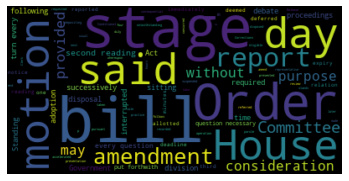

In [57]:
wordcloud_df = pd.read_sql_query(
    "SELECT  id AS vote_question_id, date as vote_date, description_en \
     FROM bills_votequestion", conn)
text = wordcloud_df.description_en[0]
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now to make one for every description combined.

In [59]:
bigstring = ''
for x in range(wordcloud_df.shape[0]):
    bigstring +=(wordcloud_df.description_en[0])

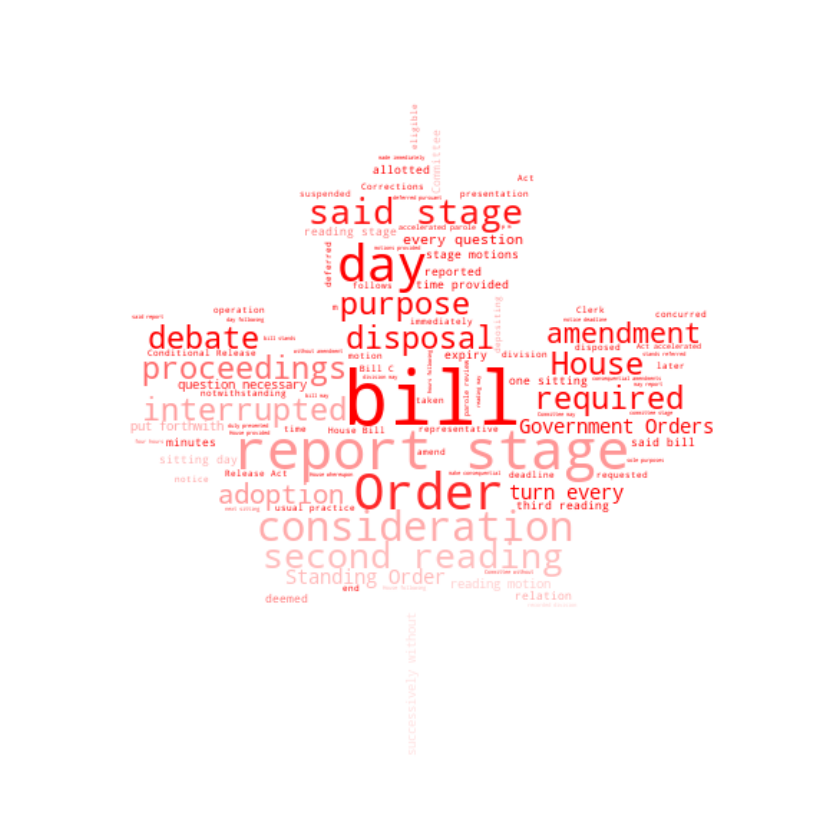

In [60]:
stopwords = set(STOPWORDS)
mask = np.array(Image.open("Leaf.png").convert('RGB'))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(bigstring)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

In [62]:
conn.close()